# Inter-subjects correlation (figure 1)

### Importing functions

In [2]:
import matplotlib as mpl
import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
from lempel_ziv_complexity import lempel_ziv_complexity
import seaborn as sns

import saving as sv
import avalanches as av
import Utils_FC as fc

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS

#main definition:

sound_list=['speech','music', 'rest']

#colors for plotting 
col_s='#8CCC94'
col_m='#FCAC74'
col_r='#6CA4CC'

colors={}
colors['rest'] = '#6CA4CC'
colors['speech'] = '#8CCC94'
colors['music'] = '#FCAC74'

Computation subject list 

In [3]:

sound_list=['rest','music','speech']
arr_mu = os.listdir(path +'seeg_fif_data/music')
arr_rest = os.listdir(path +'seeg_fif_data/speech')
arr_speech = os.listdir(path +'seeg_fif_data/rest')

subject_set_mu=set()
subject_set_speech=set()
subject_set_rest=set()

for st in arr_mu: 
    #print(st)
    subject_set_mu.add(st.partition('_')[0])
    #print(st.partition('_')[0])
    
for st in arr_speech:
    subject_set_speech.add(st.partition('_')[0])
    
for st in arr_rest:
    subject_set_rest.add(st.partition('_')[0])

subject_list=list(subject_set_mu.intersection(subject_set_speech,subject_set_rest))

#Here I create a set of the  all channels
total_channels_set=set()

for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)

#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)





### Uploading data, channels and subject list

In [5]:
ch_H_i={}
zdata={}
for isub, subject in enumerate(subject_list):
    print(subject)
    zdata[subject]={}
    
    
    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
        #print(f.keys())
        #print('chnames', f['chnames'].shape)

        chnames = f['chnames'][...].astype('U')
        x=f['chlocs']

    #Here we load the list of bad channels
    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
        #print(f.keys())
        #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
        #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

    ## Cleaning from artifacts
    #List of bad channels indices
    ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

    clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
    ch_H_i[subject]= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]
    
    print(ch_H_i[subject])
    
sv.saving(ch_H_i, path+"H_channels_indices_subjects")
    
    

sub-82e330f8aadd
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
sub-e0bb6ccef2a5
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
sub-ebf231d97f73
[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 139, 140, 141, 142, 143, 144, 145]
sub-44375d501493
[100, 101, 102, 103, 104, 105, 106]
sub-28e70e7c7fbb
[9, 10, 11, 12, 13, 14, 108, 109, 110, 111, 112, 113, 114, 115, 116]
sub-95a634be7e05
[83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122]
sub-cacae171ee15
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 86, 87, 88, 89, 90, 91, 92, 93, 94]
sub-fccb4adbfadc
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108]
sub-14c725b6b803
[29, 30, 31, 32, 33, 34, 35, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
sub-26176ef8a8d0
[32, 33, 34, 35, 36, 37, 38, 39, 66, 67, 68, 69, 70, 71, 72]
sub-a4e7fc9d

In [6]:

#PARAMETERS

dataused=''

subject_list=subject_list

final_channels_without_H={}

final_channels_H={}

final_channels_all={}

dataused='without_H'

datatipe="hgenv_down100"

zdata={}

ch_H_i={}
for isub, subject in enumerate(subject_list):
    
    zdata[subject]={}
    
    for sound in sound_list:
    
        ## Load the data from the HDF fil
        #print(subject, isub)    
        #Loading the data
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        #List of indices of H channels, list of indices of not H channels
        ch_H_i[subject]= [i for i, ch in enumerate(clean_chnames) if ch not in ch_H]
        ch_H_w_i= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]

        #dictionaries with subjects ad keys and channels names
        final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i in ch_H_i[subject]]
        final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i[subject]]
        final_channels_all[subject]=clean_chnames

        #The final channels that we used
        final_channels=clean_chnames


        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus
        clean_H = np.delete(clean, ch_H_i[subject], axis=0)

        #only the channels not in the helsch gyrus
        clean_without_H = np.delete(clean, ch_H_w_i, axis=0)

        #clean_mu=clean2(clean_music_H, N=3)
        #clean_sp=clean2(clean_speech_H, N=3)
        #clean_re=clean2(clean_rest_H, N=3)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        
        #zscored computed again
        zdata[subject][sound]=stats.zscore(zdata_, axis=1)
    
#sv.saving(zdata, path+"data_subject_sound_" + datatipe)
#sv.saving(ch_H_i, path+"H_channels_indices_subjects")
        if subject==  'sub-e0bb6ccef2a5':
            print(zdata[subject][sound].shape)


(110, 56670)
(110, 57837)
(110, 57470)


In [7]:
#datatipe="hgenv_down100"
ap={} #here the activity profile of each subject is stored
#data=sv.loading( path+"data_subject_sound_" + datatipe)
for subject in subject_list:
    ap[subject]={}
    avalanches={}
    
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata[subject]['rest'], 99)
    print(thres)
    
    for sound in sound_list:
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)

        ap[subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)
        

3.334984151824247
2.78534246404477
2.750861898649132
2.897258743666651
2.803148765547773
2.7331326834817284
2.734310175019014
2.8552720483703933
2.7507264122036497
2.79738475441734
2.7742837529435107
2.8089245753814596
2.7985919037396925
2.8138171563785437
2.7761437719778965
2.818625307029934
2.774284818922206
2.9744978125454247
2.7654285000333187


Here we create a matrix, whose lines are ap of different subjects

In [8]:

ap_matrix={} 
for sound in sound_list:
    ap_matrix[sound]=np.zeros((len(subject_list), len(ap[subject_list[0]][sound])))
    for isub, subject in enumerate(subject_list):
        ap_matrix[sound][isub,:]=ap[subject][sound]
    

Here the correlation matrices (subject x subject) are computed, using the Pearson correlation. Also using the Spearman correlation the results are significant

In [9]:
corr_matrix={}
for sound in sound_list:
    corr_matrix[sound]=np.corrcoef(ap_matrix[sound])  
    

Here the correlation matrices are plotted.

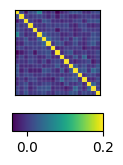

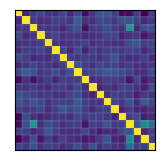

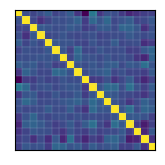

In [10]:
sv.saving(corr_matrix, 'matrix_corr_'+dataused)
vm=0.2
cl='viridis'

for sound in sound_list:
    
    a,b=0,0.1
    plt.figure(figsize=(1.75,1.75))
    #plt.title('Backbone',fontsize=MEDIUM_SIZE)
    plt.imshow(corr_matrix[sound],cmap=cl,interpolation='nearest',vmax=vm,)
    for i in range(len(subject_list)):
        plt.axvline(i-0.5,linewidth=0.15,color='lightsteelblue')
        plt.axhline(i-0.5,linewidth=0.15,color='lightsteelblue')
    plt.yticks([])
    plt.xticks([])
    if sound=='rest':
        plt.colorbar(orientation = 'horizontal', shrink=1, aspect=5)
    plt.tight_layout()
    #plt.savefig('dyn_corr_matrix_AP_colorbar'+sound+'_'+dataused+'.png', dpi=600)
    plt.show()

### Here we compute the p value between the different correlation matrices

In [11]:
stats.wilcoxon(corr_matrix['music'][np.triu_indices(19, k = 1)],corr_matrix['rest'][np.triu_indices(19, k = 1)])[1]

2.2346957569150894e-05

Surrogate data procedure

In [12]:
list_mean_corr={}

num_it=1000
for sound in sound_list:
    list_mean_corr[sound]=[]

    for i in range(num_it):

        ap_shift=av.shifting_matrix(ap_matrix[sound])
        list_mean_corr[sound].append(np.mean(np.corrcoef(ap_shift)[np.triu_indices(19, k = 1)]))
for sound in sound_list:
    
    plt.figure(figsize=(3.5,2.6))
    plt.hist(list_mean_corr[sound], label='random shift')
    plt.axvline(x=np.mean(np.corrcoef(ap_matrix[sound])[np.triu_indices(19, k = 1)]), label='our result')
    plt.title(sound, fontsize=14)
    plt.legend(fontsize=8)
    plt.savefig(path+'figure/comparison_null_music_env_H'+dataused+'.png', dpi=600)
    plt.show()
    plt.close()
    
sv.saving(list_mean_corr, path+"list_random_correlation_dict"+dataused)

AttributeError: module 'avalanches' has no attribute 'shifting_matrix'

In [12]:
bin_size_max = 2000
binsizes=np.arange(1, bin_size_max+1)

ap = {}
ap_matrix = {}
list_mean_corr = {}
z_stats={}
real_intersubcorr={}
real_intersubcorr_std={}
p_value_speech_music = {}
p_value_speech_rest = {}
p_value_music_rest = {}

for bins in binsizes:

    #datatipe="hgenv_down100"
    ap[bins]={} #here the activity profile of each subject is stored
    #data=sv.loading( path+"data_subject_sound_" + datatipe)
    for subject in subject_list:
        ap[bins][subject]={}
        avalanches={}
        
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata[subject]['rest'], 99)
        
        for sound in sound_list:
            
            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=bins)

            ap[bins][subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)

    real_intersubcorr[bins]={}
    real_intersubcorr_std[bins]={}

    ap_matrix[bins]={} 
    for sound in sound_list:
        ap_matrix[bins][sound]=np.zeros((len(subject_list), len(ap[bins][subject_list[0]][sound])))
        for isub, subject in enumerate(subject_list):
            ap_matrix[bins][sound][isub,:]=ap[bins][subject][sound]
        real_intersubcorr[bins][sound] = np.mean(np.corrcoef(ap_matrix[bins][sound])[np.triu_indices(19, k = 1)]) 
        real_intersubcorr_std[bins][sound] = np.std(np.corrcoef(ap_matrix[bins][sound])[np.triu_indices(19, k = 1)]) 

    p_value_speech_music[bins]=stats.wilcoxon(np.corrcoef(ap_matrix[bins]['speech'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix[bins]['music'])[np.triu_indices(19, k = 1)])[1]
    p_value_speech_rest[bins]=stats.wilcoxon(np.corrcoef(ap_matrix[bins]['speech'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix[bins]['rest'])[np.triu_indices(19, k = 1)])[1]
    p_value_music_rest[bins]=stats.wilcoxon(np.corrcoef(ap_matrix[bins]['music'])[np.triu_indices(19, k = 1)], np.corrcoef(ap_matrix[bins]['rest'])[np.triu_indices(19, k = 1)])[1]

    

In [16]:
sv.saving(real_intersubcorr, 'results_Binsizes_mean_corr_dict')
sv.saving(real_intersubcorr_std, 'results_Binsizes_std_corr_dict')
sv.saving(p_value_speech_music, 'results_Binsizes_p_spmu_dict')
sv.saving(p_value_speech_rest, 'results_Binsizes_p_spre_dict')
sv.saving(p_value_music_rest, 'results_Binsizes_p_mure_dict')


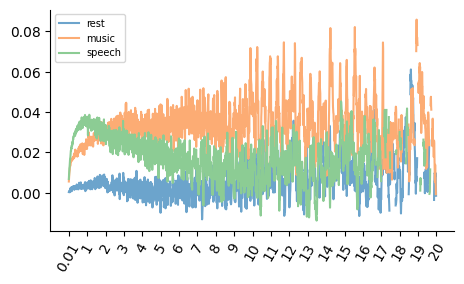

In [50]:
binsizes=np.arange(1, bin_size_max)
max_bin_forplot=2000

plt.figure(figsize=(5,3.2))

bin_rel_corrtoplot={}
for sound in sound_list:
    bin_rel_corrtoplot[sound]=[]

    for bins in binsizes[:max_bin_forplot]:

        bin_rel_corrtoplot[sound].append(real_intersubcorr[bins][sound])

    plt.plot(bin_rel_corrtoplot[sound], color=colors[sound], label=sound)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
xtick=list(np.arange(0,21))
xtick[0]=0.01
plt.xticks(np.arange(0,2001)[::100], xtick , rotation=60)
plt.tight_layout(pad=2)
plt.savefig('binsizes_effect_max_1000.png', dpi=600)
plt.legend(fontsize=7)
plt.show()
plt.close()

sv.saving(bin_rel_corrtoplot, path+'results_Binsizes_mean_corr_dict')


In [ ]:
th_max=99
th_min=50
ap_th = {}
ap_matrix_th = {}
list_mean_corr_th = {}
z_stats_th={}
real_intersubcorr_th={}
real_intersubcorr_th_std={}
thresholds = np.arange(th_min,th_max)


for th in thresholds:

    #datatipe="hgenv_down100"
    ap_th[th]={} #here the activity profile of each subject is stored
    #data=sv.loading( path+"data_subject_sound_" + datatipe)
    for subject in subject_list:
        ap_th[th][subject]={}
        avalanches={}
        
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(np.abs(zdata[subject]['rest']), th)
        
        for sound in sound_list:
            
            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)

            ap_th[th][subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)

    real_intersubcorr_th[th]={}
    real_intersubcorr_th_std[th]={}
    ap_matrix_th[th]={} 
    for sound in sound_list:
        ap_matrix_th[th][sound]=np.zeros((len(subject_list), len(ap_th[th][subject_list[0]][sound])))
        for isub, subject in enumerate(subject_list):
            ap_matrix_th[th][sound][isub,:]=ap_th[th][subject][sound]
        real_intersubcorr_th[th][sound] = np.mean(np.corrcoef(ap_matrix_th[th][sound])[np.triu_indices(19, k = 1)]) 
        real_intersubcorr_th_std[th][sound]= np.std(np.corrcoef(ap_matrix_th[th][sound])[np.triu_indices(19, k = 1)]) 

    

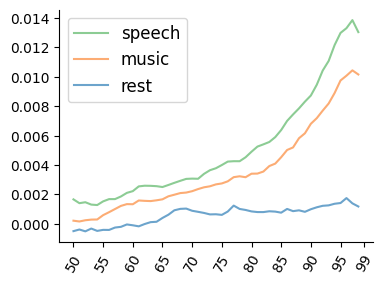

In [ ]:

th_rel_corrtoplot={}
real_intersubcorr_th_stdtoplot={}

plt.figure(figsize=(4.2,3.2))
for sound in sound_list:
    th_rel_corrtoplot[sound]=[]
    real_intersubcorr_th_stdtoplot[sound]=[]
    for th in thresholds:

        th_rel_corrtoplot[sound].append(real_intersubcorr_th[th][sound])
        real_intersubcorr_th_stdtoplot[sound].append(real_intersubcorr_th_std[th][sound])
    plt.plot(th_rel_corrtoplot[sound],  color=colors[sound], label=sound)

xticks=list(np.arange(50,99,5))
xticks.append(99)
aa=list(np.arange(0,49,5))
aa.append(49)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(aa, xticks, rotation=60)
plt.legend(fontsize=12)
plt.tight_layout(pad=2)
plt.savefig('threshold_effect_max.png', dpi=600)
plt.show()
plt.close()

sv.saving(bin_rel_corrtoplot, path+'results_Binsizes_mean_corr_dict')



In [ ]:
for bins in range(bin_size_max):

    list_mean_corr[bins]={}


    num_it=1000
    for sound in sound_list:
        list_mean_corr[bins][sound]=[]

        for i in range(num_it):

            ap_shift=av.shifting_matrix(ap_matrix[bins][sound])
            list_mean_corr[bins][sound].append(np.mean(np.corrcoef(ap_shift)[np.triu_indices(19, k = 1)]))
    
    z_stats[bins]={}

    for sound in sound_list:
        
        x = np.mean(np.corrcoef(ap_matrix[bins][sound])[np.triu_indices(19, k = 1)])
        z_stat[bins][sound].append(real_intersubcorr[bins][sound]-np.mean(list_mean_corr[bins][sound]))/(np.std))
        

In [56]:
list_random= sv.loading(path+"list_random_correlation_dict_H"+dataused)

In [57]:
for sound in sound_list:
    p=np.sum(np.where(list_random[sound]>np.mean(np.corrcoef(rss_matrix[sound])[np.triu_indices(19, k = 1)]),1,0))/1000
    print(sound, p)

rest 0.411
music 0.098
speech 0.007


### Here we compute the intersubject correlation samplig one channel per region

In [4]:
n_iteration=1000

zdata={}
real_corr_sim={}
null_mod_corr_sim={}

for sound in sound_list:

    real_corr_sim[sound]=list()
    null_mod_corr_sim[sound]=list()

for n in range(n_iteration):
    
    print(n)


    for subject in subject_list:
        zdata[subject]={}
        for sound in sound_list:
            with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('music', f['music'].shape)

                #data_music[subject]=f['music'][...]
                data_raw=f[sound][...]
                
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

            #Here we load the channels names
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                
                #print(f.keys())
                #print('chnames', f['chnames'].shape)

                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']

            #Here we load the list of bad channels
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
                #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
                #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]


            ## Cleaning from artifacts
            #List of bad channels indices
            ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

            clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

            with h5py.File(pjoin(path+'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                
                chnames = f['chnames'][...].astype('U')
                
                at=f['atlasses']['Brainnetome'][...]
            
            listR=[a[:13] for a in at]
            list_goodR=np.delete(listR, ch_i)
            setR=list(dict.fromkeys(list_goodR))
            good_indices=[]
            
            for i in setR:
                
                indices=[j for j, r in enumerate(list_goodR) if r==i]
                good_indices.append(np.random.choice(indices))

            
            clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
            ch_i_sim = [i for i, ch in enumerate(clean_chnames) if i not in good_indices]
            clean_chnames_sim= [ch for i, ch in enumerate(clean_chnames) if i in good_indices]
            
            clea = np.delete(data_raw, ch_i, axis=0)

            clean= np.delete(clea,  ch_i_sim, axis=0)

            #List of indices of H channels, list of indices of not H channels
            ch_H_i[subject]= [i for i, ch in enumerate(clean_chnames_sim) if ch not in ch_H]
            ch_H_w_i= [i for i, ch in enumerate(clean_chnames_sim) if ch in ch_H]

            #dictionaries with subjects ad keys and channels names
            final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames_sim) if i in ch_H_i[subject]]
            final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames_sim) if i not in ch_H_i[subject]]
            final_channels_all[subject]=clean_chnames_sim

            #The final channels that we used
            final_channels=clean_chnames_sim


            #HERE WE CREATE THE DATA SET, THAT WE USE
            #only the channels in Helsch gyrus
            clean_H = np.delete(clean, ch_H_i[subject], axis=0)

            #only the channels not in the helsch gyrus
            clean_without_H = np.delete(clean, ch_H_w_i, axis=0)

            #clean_mu=clean2(clean_music_H, N=3)
            #clean_sp=clean2(clean_speech_H, N=3)
            #clean_re=clean2(clean_rest_H, N=3)

            #zscore of the data
            zdata_art=stats.zscore(clean, axis=1)

            #the artifacts are substituted by 0
            zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

            #zscored computed again
            zdata[subject][sound]=stats.zscore(zdata_, axis=1)
    
    #datatipe="hgenv_down100"
    ap={} #here the activity profile of each subject is stored
    #data=sv.loading( path+"data_subject_sound_" + datatipe)
    for subject in subject_list:
        ap[subject]={}
        avalanches={}
        
        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata[subject]['rest'], 99)
        #print(thres)
        
        for sound in sound_list:
            
            #avalanches dictionaries are computed using the functions of Utils_avalanches.py
            avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)

            ap[subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)
            
    ap_matrix={} 
    for sound in sound_list:
        ap_matrix[sound]=np.zeros((len(subject_list), len(ap[subject_list[0]][sound])))
        for isub, subject in enumerate(subject_list):
            ap_matrix[sound][isub,:]=ap[subject][sound]   
                

0


NameError: name 'ch_H_i' is not defined

In [11]:
sv.saving(real_corr_sim, 'results_sim_random_picking_1perregion')
sv.saving(null_mod_corr_sim, 'results_null_model_sim_random_picking_1perregion')

In [10]:
real_corr_sim = sv.loading('results_sim_random_picking_1perregion')
null_mod_corr_sim = sv.loading('results_null_model_sim_random_picking_1perregion')

In [11]:
for sound in sound_list:
    real_corr_sim[sound] = np.array(real_corr_sim[sound])
    null_mod_corr_sim[sound] = np.array(null_mod_corr_sim[sound])

9.988276972830283e-48
0.0
0.0
Ttest_indResult(statistic=14.906233064877647, pvalue=9.988276972830283e-48)
Ttest_indResult(statistic=75.7654775417233, pvalue=0.0)
Ttest_indResult(statistic=57.450744212169816, pvalue=0.0)


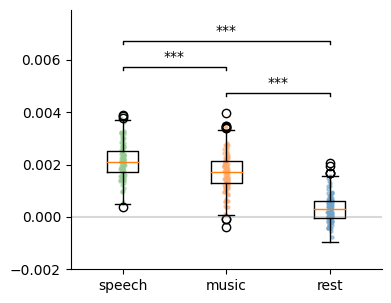

In [111]:

C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc'}
#C2 = {     'sr': '#803b7f',    'mr': '#c0896f',    'sm': '#b6d12d'}
plt.figure(figsize=(3.7,3))

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# dist_sp_re1=real_corr_sim['speech']-null_mod_corr_sim['speech']
# dist_re_mu1=real_corr_sim['music']-null_mod_corr_sim['music']
# dist_sp_mu1=real_corr_sim['rest']-null_mod_corr_sim['rest']

dist_sp_re1=real_corr_sim['speech']
dist_re_mu1=real_corr_sim['music']
dist_sp_mu1=real_corr_sim['rest']

#plt.axhline(0,alpha=0.3, linestyle=':',color='k')
box_plot_data=[dist_sp_re1,dist_re_mu1,dist_sp_mu1]#[left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']]
for i in np.arange(len(dist_sp_mu1))[::10]:
    spmu=dist_sp_mu1[i]
    remu=dist_re_mu1[i]
    spre=dist_sp_re1[i]
    eps1=(np.random.rand()-.5)*((1-spre*100))*0.05
    eps2=(np.random.rand()-.5)*((1-remu*100))*0.05
    eps3=(np.random.rand()-.5)*((1-spmu*100))*0.05
    plt.scatter(1+eps1,spre,color=C1['s'],alpha=.5, s=5)#color=C2['sr']
    plt.scatter(2+eps2,remu,color=C1['m'],alpha=.5, s=5)#color=C2['mr'],
    plt.scatter(3+eps3,spmu,color=C1['r'],alpha=.5, s=5)#color=C2['sm']

    # plt.scatter(1,spre,color=C1['s'],alpha=.5)
    # plt.scatter(2,remu,color=C1['m'],alpha=.5)
    # plt.scatter(3,spmu,color=C1['m'],alpha=.9)
    # plt.scatter(1,spre,color=C1['r'],alpha=.5)
    # plt.scatter(2,remu,color=C1['r'],alpha=.5)
    # plt.scatter(3,spmu,color=C1['s'],alpha=.5)
    '''if spre-remu<0:
        plt.plot([1,2],[spre,remu],color='grey',alpha=0.4)
    else:
        plt.plot([1,2],[spre,remu],color='grey',alpha=0.4,linestyle='--')

    if spmu-remu<0:
        plt.plot([3,2],[spmu,remu],color='grey',alpha=0.4)
    else:
        plt.plot([3,2],[spmu,remu],color='grey',alpha=0.4,linestyle='--')'''

plt.boxplot(box_plot_data,patch_artist=False,labels=['speech','music','rest'])
psrmr=stats.ttest_ind(dist_sp_re1,dist_re_mu1)[1]
psrsm=stats.ttest_ind(dist_sp_re1,dist_sp_mu1)[1]
pmrsm=stats.ttest_ind(dist_re_mu1,dist_sp_mu1)[1]

print(psrmr)
print(psrsm)
print(pmrsm)
print(stats.ttest_ind(dist_sp_re1,dist_re_mu1))
print(stats.ttest_ind(dist_sp_re1,dist_sp_mu1))
print(stats.ttest_ind(dist_re_mu1,dist_sp_mu1))

# p=Gtest(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music'])
# print('Gio test  ', p)
# print(stats.wilcoxon(left_increase_list['speech']-right_increase_list['speech'],left_increase_list['music']-right_increase_list['music']))
# print('p_value music - speech ', pp)
# print('p_value music - rest ', psr)
# print('p_value music - rest ', pmr)

to_min1=np.array([dist_sp_re1,dist_re_mu1,dist_sp_mu1])
bottom1, top1 = np.min(to_min1), np.max(to_min1)
bars_diff(psrmr, bottom1, top1,height=3.5)
bars_diff(psrsm, bottom1, top1,x1=1,x2=3,height=5.5)
bars_diff(pmrsm, bottom1, top1,x1=2,x2=3,height=1.5)
plt.tight_layout(pad=0.35)
plt.axhline(0, color='grey', alpha = 0.3)
plt.ylim((-0.002,0.0079))

plt.savefig('sorciere/figure/figure_1/one_ch_per_reg_intersub_corr_reali.png', dpi=600)
# plt.show()
# plt.close()


In [103]:
for sound in sound_list:
    p=np.sum(np.where((real_corr_sim[sound]) < 0, 1,0))/1000
    print(p,sound)

0.0 speech
0.003 music
0.261 rest


## p values computations


In [44]:
for sound in sound_list:
    pp=scipy.stats.ttest_ind(real_corr_sim[sound],null_mod_corr_sim[sound], equal_var=False)
    print(sound, pp)


rest Ttest_indResult(statistic=11.023912271427552, pvalue=2.264567815443565e-27)
music Ttest_indResult(statistic=60.04595860267133, pvalue=0.0)
speech Ttest_indResult(statistic=77.502194727763, pvalue=0.0)
